# Sentiment Analysis: Large Movie Review Dataset

Hi again! You will be expected to finish this on your own, but you can use the available channels on Discord to ask questions and help others. Please read the entire notebook before starting, this will give you a better idea of what you need to accomplish.

This project is related to NLP. As you may already know, the most important and hardest part of an NLP project is pre-processing, which is why we are going to focus on that.

Regarding the data, we are not going to have a __csv file__, that would be too easy :) instead we are going to download the data from [AI Stanford Dataset](https://ai.stanford.edu/~amaas/data/sentiment/). When you download them you will notice that their format is text files, so you will have to work a little there to be able to use and process them. This is a dataset for __binary sentiment classification__.

Basically a basic sentiment analysis problem, as in this case, consists of a classification problem, where the possible output labels are: `positive` and `negative`. Which indicates, if the review of a movie speaks positively or negatively. In our case it is a binary problem, but one could have many more "feelings" tagged and thus allow a more granular analysis.

### These are the objectives of the project:

* Read data that is not in a traditional format.
* Put together a set of preprocessing functions that we can use later on any NLP or related problems.
* Vectorize the data in order to apply a machine learning model to it: using BoW or TF-IDF.
* BoW and TF-IDF are classic ways to vectorize text, but currently we have some more complex ways with better performance, for this we are going to train our own word embedding and use it as a vectorization source for our data.
* Train a sentiment analysis model that allows us to detect positive and negative opinions in movie reviews.

In [84]:
import text_normalizer
import text_normalizer
import nltk
import evaluation
import utils
import os
# Bag of words
from sklearn.feature_extraction.text import CountVectorizer
# TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer
# Models
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
# Custom Embeddings
import gensim
from gensim.models import Word2Vec
from nltk.tokenize.toktok import ToktokTokenizer
from gensim.models.phrases import Phrases, ENGLISH_CONNECTOR_WORDS
import numpy as np
# Pre-Trained model
import gensim.downloader

---
## 1. Get the data

#### Download the data and process it in order to obtain:

* `X_train:` list with reviews for training.
* `y_train:` list with labels for training.
* `X_test:` list with reviews for testing.
* `y_test:` list with labels for testing.

`Notes:` Use the target column as `positive`, that way the positive value will be indicated with a value of `1` and negative with a value of `0`. In this case, a split train/test is not necessary because the original data is already separated.

In [56]:
X_train, y_train, X_test, y_test = utils.load_data('aclImdb/')

### *Don't change anything in this block, just make it run correctly*

We are going to check that you have done it right and for that we are going to see if the dimensions match.

In [4]:
def check_data(X_train, y_train, X_test, y_test):
    if len(X_train) == len(y_train) == len(X_test) == len(y_test) == 25000:
        print('Reading Data Success!')
    else:
        raise ValueError('Dimensions do not match!')

check_data(X_train, y_train, X_test, y_test)

Reading Data Success!


---
## 2. Normalize the data

#### Create the following functions but not here in the notebook, do it in the python script called `text_normalizer.py` and import them into the notebook (this way you can build your own NLP preprocessing library). In fact, the structure of the functions is already written, you must complete them with the code that you consider necessary.

#### Respect names and minimal interfaces:

* `remove_html_tags(text):` to remove all HTML tags that may be present in text.
* `remove_accented_chars(text):` to remove accented characters from text
* `expand_contractions(text):` to expand contractions of the type, "don't" to "do not". The contractions are already defined in the "contractions.py" file.
* `lemmatize_text(text):` to lemmatize text.
* `stem_text(text):` to apply stemming (NLTK's PorterStemmer) on text.
* `remove_special_chars(text):` to remove special characters from text.
* `remove_special_chars(text, remove_digits=True):` to remove numbers, note that it is the same function to remove special characters with the addition of an argument that enables or disables the removal of numbers.
* `remove_stopwords(text, stopwords=stop_words):` to remove stopwords from text.
* `remove_extra_new_lines(text):` to remove extra newlines from text.
* `remove_extra_whitespace(text):` to remove extra whitespaces from text.

If you want to add more features that would be great, for example you could start by removing emojis, using different stemming algorithms, etc. The more functions you have the better, remember that the texts are very varied and the preprocessing depends a lot on the source of our data.

To apply each of the functions you created and pre-process the dataset, you must use the `normalize_corpus` function of the `text_normalizer.py` script. In this method each of the functions you wrote is called, in fact you must enable or disable what you consider necessary (`at this point we leave it to your free choice, for example: you can lemmatize or apply stemming or directly not apply any of the two and so on with the rest, but that is your choice`), this function simply groups the previous ones for a more simplified use.

In [57]:
# Load and split data set
X_train_n_lemma, X_test_n_lemma = utils.load_object('norm_data_lemma.pickle')

In [79]:
try:
  X_train_n, X_test_n             = utils.load_object('norm_data.pickle')
  X_train_n_stem, X_test_n_stem   = utils.load_object('norm_data_stem.pickle')
  X_train_n_lemma, X_test_n_lemma = utils.load_object('norm_data_lemma.pickle')
except:
  X_train_n, X_test_n             = utils.save_object(text_normalizer.normalize_data((X_train, X_test)), 'norm_data.pickle')
  print('Default data normalization completed!')
  X_train_n_stem, X_test_n_stem   = utils.save_object(text_normalizer.normalize_data((X_train, X_test), text_stemming=True), 'norm_data_stem.pickle')
  print('Stemmed data normalization completed!')
  X_train_n_lemma, X_test_n_lemma = utils.save_object(text_normalizer.normalize_data((X_train, X_test), text_lemmatization=True), 'norm_data_lemma.pickle')
  print('Lemmatized data normalization completed!')


Default data normalization completed!
Stemmed data normalization completed!
Lemmatized data normalization completed!


![text_notmalizer v1 output](resources/text_normalizarer_v1_output.PNG)

We see that we have different amount of 'tokens' deppending on if we do stemming, lemmatization or neither of them. This is because the removal of stop words should be applied before this steps in order to capture all the stop words in the document. Also I consider lowering the woirds in the documents should be applied earlier in the normaliztion chain (As opposed to the pipeline recommended [here](https://towardsdatascience.com/nlp-building-text-cleanup-and-preprocessing-pipeline-eba4095245a0) ). Let's make these modifications in the text_normalizer and try again

In [6]:
# Lets make a quick inspection
print(X_train_n[0][0:60], len(X_train_n[0].split()))
print(X_train_n_stem[0][0:60], len(X_train_n_stem[0].split()))
print(X_train_n_lemma[0][0:60], len(X_train_n_lemma[0].split()))

movie heard life growing never seen years ago reputation tru 168
movi heard life grow never seen year ago reput truli proceed 168
movie hear life growing never see year ago reputation truly  168


We have more consistent results now.

### *Don't change anything in this block, just make it run correctly*

We are going to check that the pre-processing does what we need it to do, for this we are going to test the functions with predefined inputs and we are going to see if the outputs match what we are looking for.

Note that the functions are not defined in the notebook itself, but rather that they are in a python file and you must import them in order to use them. Same thing with names, you're going to have to name your functions the way they were named.

In [7]:
# Inputs
doc_html = """
<br /><br />But with plague out there and the news being kept a secret,
the New Orleans PD starts a dragnet of the city's underworld.
"""
doc_accented = "Héllo, thís is an accented sénténce."
doc_contractions = "I can't, because it doesn't work."
doc_lemma = "The striped bats are hanging on their feet for best"
doc_stem = """
Where did he learn to dance like that?
His eyes were dancing with humor.
She shook her head and danced away.
"""
doc_specials = "hello? there A-Z-R_T(,**), world, welcome to python. this **should? the next line#followed- by@ an#other %million^ %%like $this."
doc_digits = "abc123def456ghi789zero0 hello my friend number 10"
doc_stop = "He is a very good person"
doc_new_lines = """we
use
a
lot
of
lines"""
doc_spaces = "Hello           my      dear          friend"

# Outputs
good_html = """
But with plague out there and the news being kept a secret,
the New Orleans PD starts a dragnet of the city's underworld.
"""
good_accented = "Hello, this is an accented sentence."
good_contractions = "I cannot, because it does not work."
good_lemma = "the stripe bat be hang on their foot for good"
good_stem = "where did he learn to danc like that ? hi eye were danc with humor. she shook her head and danc away ."
good_specials = "hello there AZRT world welcome to python this should the next linefollowed by another million like this"
good_digits = "abcdefghizero hello my friend number "
good_stop = "good person"
good_new_lines = "we use a lot of lines"
good_spaces = "Hello my dear friend"
stop_words = nltk.corpus.stopwords.words('english')

def check_normalization():
    if good_html == text_normalizer.remove_html_tags(doc_html):
        print('[1/10] Remove HTML Success!')
    else:
        raise ValueError('[1/10] Remove HTML Fail!')
        
    if good_accented == text_normalizer.remove_accented_chars(doc_accented):
        print('[2/10] Remove Accented Success!')
    else:
        raise ValueError('[2/10] Remove Accented Fail!')
        
    if good_contractions == text_normalizer.expand_contractions(doc_contractions):
        print('[3/10] Expand Contractions Success!')
    else:
        raise ValueError('[3/10] Expand Contractions Fail!')
        
    if good_lemma == text_normalizer.lemmatize_text(doc_lemma):
        print('[4/10] Lemmatization Success!')
    else:
        raise ValueError('[4/10] Lemmatization Fail!')
    
    if good_stem == text_normalizer.stem_text(doc_stem):
        print('[5/10] Stemming Success!')
    else:
        raise ValueError('[5/10] Stemming Fail!')
        
    if good_specials == text_normalizer.remove_special_chars(doc_specials):
        print('[6/10] Remove Specials Success!')
    else:
        raise ValueError('[6/8] Remove Specials Fail!')
        
    if good_digits == text_normalizer.remove_special_chars(doc_digits, remove_digits=True):
        print('[7/10] Remove Digits Success!')
    else:
        raise ValueError('[7/10] Remove Digits Fail!')
        
    if good_stop == text_normalizer.remove_stopwords(doc_stop, stopwords=stop_words):
        print('[8/10] Remove Stopwords Success!')
    else:
        raise ValueError('[8/10] Remove Stopwords Fail!')
    
    if good_new_lines == text_normalizer.remove_extra_new_lines(doc_new_lines):
        print('[9/10] Remove New Lines Success!')
    else:
        raise ValueError('[9/10] Remove New Lines Fail!')
        
    if good_spaces == text_normalizer.remove_extra_whitespace(doc_spaces):
        print('[10/10] Remove Extra Whitespaces Success!')
    else:
        raise ValueError('[10/10] Remove Extra Whitespaces Fail!')

check_normalization()

[1/10] Remove HTML Success!
[2/10] Remove Accented Success!
[3/10] Expand Contractions Success!
[4/10] Lemmatization Success!
[5/10] Stemming Success!
[6/10] Remove Specials Success!
[7/10] Remove Digits Success!
[8/10] Remove Stopwords Success!
[9/10] Remove New Lines Success!
[10/10] Remove Extra Whitespaces Success!


---
## 3. Feature Engineering

You already have the pr-eprocessed data, now you must vectorize them, because remember that the models only understand numbers. At this stage choose whether you want to vectorize with BoW or with TF-IDF. Later we will train our own embedding but for now we go with a more "classic" vectorization.

In [10]:
# Bag of Words
cv = CountVectorizer()
cv_n2 = CountVectorizer(ngram_range=(1,2))
B_O_W_train       = cv.fit_transform(X_train_n)
B_O_W_test        = cv.transform(X_test_n)
B_O_W_train_stem  = cv.fit_transform(X_train_n_stem)
B_O_W_test_stem   = cv.transform(X_test_n_stem)
B_O_W_train_lemma = cv.fit_transform(X_train_n_lemma)
B_O_W_test_lemma  = cv.transform(X_test_n_lemma)

B_O_W_train_n2 = cv_n2.fit_transform(X_train_n)
B_O_W_test_n2  = cv_n2.transform(X_test_n)


In [87]:
# TF-IDF
vectorizer = TfidfVectorizer()
vectorizer_n2 = TfidfVectorizer(ngram_range=(1,2))
TFIDF_train       = vectorizer.fit_transform(X_train_n)
TFIDF_test        = vectorizer.transform(X_test_n)
TFIDF_train_stem  = vectorizer.fit_transform(X_train_n_stem)
TFIDF_test_stem   = vectorizer.transform(X_test_n_stem)
TFIDF_train_lemma = vectorizer.fit_transform(X_train_n_lemma)
TFIDF_test_lemma  = vectorizer.transform(X_test_n_lemma)

TFIDF_train_n2     = vectorizer_n2.fit_transform(X_train_n)
TFIDF_test_n2      = vectorizer_n2.transform(X_test_n)

## 4. Modeling and Performance Evaluation

As we said at the beginning, what interests us most in this part is pre-processing. However, we must train a model, so choose a model of your choice (obviously a classification model, given the problem we are facing) and apply everything we learned. Also if you want you can try several models, the more models you use and know better!

In addition to training the model we ask you to show:

* `Precision`
* `Recall`
* `F1-Score`
* `Classification Report`
* `Confusion Matrix`

To do this you must complete the `get_performance` function of the `evaluation.py` script.

Also, you must complete the `plot_roc` function so that it can show:

* `ROC Curve`
* `Obtain the ROC-AUC value (later we will do a small minimum performance check with this value)`

### Logistic Regression with Bag of Words

In [12]:
model = LogisticRegression(random_state = 7)
model.fit(B_O_W_train, y_train)
y_train_pred       = model.predict(B_O_W_train)
y_pred             = model.predict(B_O_W_test)

model_stem = LogisticRegression(random_state=7)
model_stem.fit(B_O_W_train_stem, y_train)
y_train_pred_stem  = model_stem.predict(B_O_W_train_stem)
y_pred_stem        = model_stem.predict(B_O_W_test_stem)

model_lemma = LogisticRegression(random_state=7)
model_lemma.fit(B_O_W_train_lemma, y_train)
y_train_pred_lemma = model_lemma.predict(B_O_W_train_lemma)
y_pred_lemma       = model_lemma.predict(B_O_W_test_lemma)

model_n2 = LogisticRegression(random_state = 7)
model_n2.fit(B_O_W_train_n2, y_train)
y_train_pred_n2    = model_n2.predict(B_O_W_train_n2)
y_pred_n2          = model_n2.predict(B_O_W_test_n2)


/home/jotace/anaconda3/envs/aaiSP5-3.8.13/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/jotace/anaconda3/envs/aaiSP5-3.8.13/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/m

#### *Don't change anything in this block, just make it run correctly*

Let's check that the `get_performance` function returns the metrics correctly. For that we are going to simulate input/output data of a model.

In [13]:
def check_basic_metrics():
    accuracy, precision, recall, f1_score = evaluation.get_performance(
        [1, 1, 1, 1, 1, 0, 0, 0, 0, 0], 
        [1, 1, 1, 0, 0, 1, 1, 0, 0, 0]
    )
    
    if (accuracy, precision, recall, f1_score) == (0.6, 0.6, 0.6, 0.6):
        print('Success!')
    else:
        raise ValueError('You must check your get_performance function!')
        
check_basic_metrics()

Model Performance metrics:
------------------------------
Accuracy: 0.6
Precision: 0.6
Recall: 0.6
F1 Score: 0.6

Model Classification report:
------------------------------
(array([0.6, 0.6]), array([0.6, 0.6]), array([0.6, 0.6]), array([5, 5]))

Prediction Confusion Matrix:
------------------------------
   0  1
0  3  2
1  2  3
Success!


Let's see if your model at least exceeds an ROC-AUC of 0.93

In [ ]:
print("*****************   Default   *****************")
accuracy, precision, recall, f1_score = evaluation.get_performance(
        y_pred, 
        y_test
    )
print("*****************   Stemming   *****************")
accuracy_stem, precision_stem, recall_stem, f1_score_stem = evaluation.get_performance(
        y_pred_stem, 
        y_test
    )

In [14]:
print("***************** Lemmatization *****************")
accuracy_lemma, precision_lemma, recall_lemma, f1_score_lemma = evaluation.get_performance(
        y_pred_lemma, 
        y_test
    )
    
print("************** Defaul ngramn=(1,2) **************")
accuracy_lemma, precision_lemma, recall_lemma, f1_score_lemma = evaluation.get_performance(
        y_pred_n2, 
        y_test
    )

*****************   Default   *****************
Model Performance metrics:
------------------------------
Accuracy: 0.8646
Precision: 0.8694770976895014
Recall: 0.858
F1 Score: 0.8637004227904168

Model Classification report:
------------------------------
(array([0.85984998, 0.8694771 ]), array([0.8712, 0.858 ]), array([0.86548778, 0.86370042]), array([12500, 12500]))

Prediction Confusion Matrix:
------------------------------
       0      1
0  10890   1610
1   1775  10725
*****************   Stemming   *****************
Model Performance metrics:
------------------------------
Accuracy: 0.85512
Precision: 0.8608943089430894
Recall: 0.84712
F1 Score: 0.8539516129032257

Model Classification report:
------------------------------
(array([0.84952756, 0.86089431]), array([0.86312, 0.84712]), array([0.85626984, 0.85395161]), array([12500, 12500]))

Prediction Confusion Matrix:
------------------------------
       0      1
0  10789   1711
1   1911  10589
***************** Lemmatization 

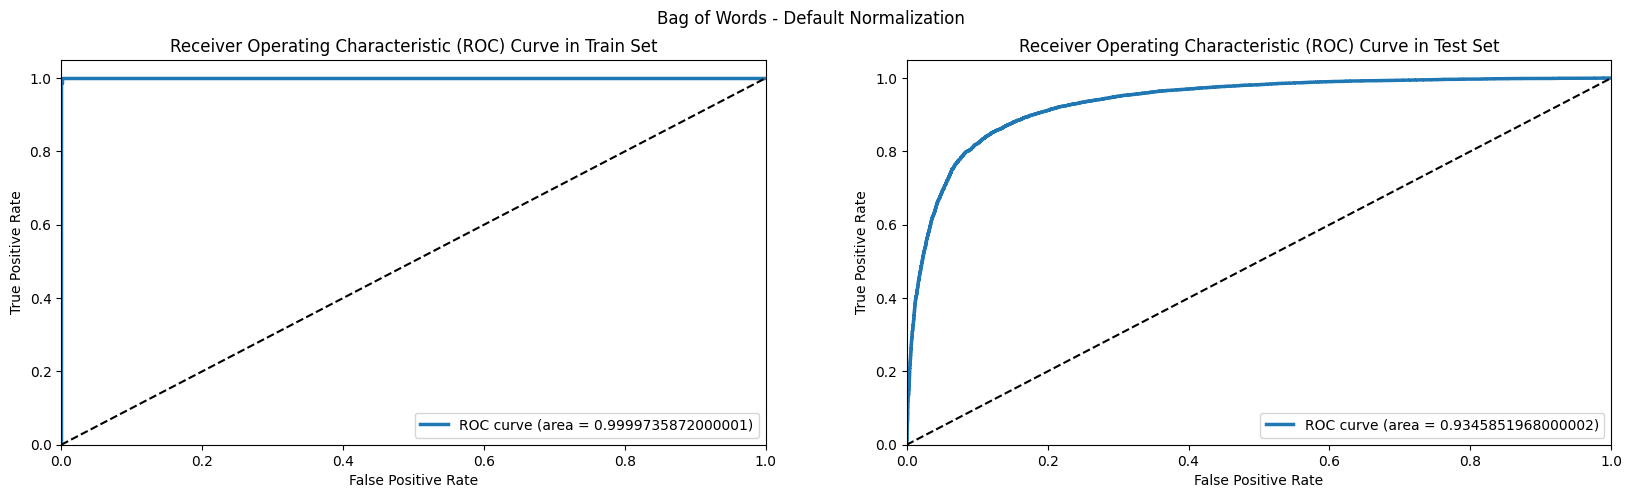

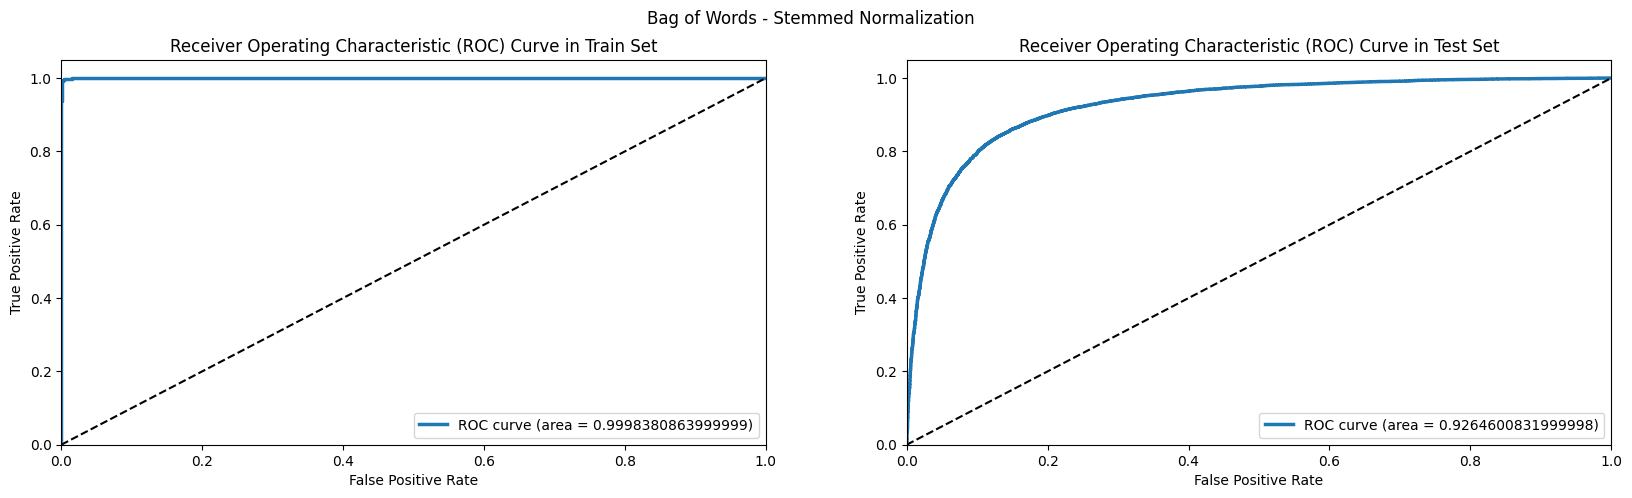

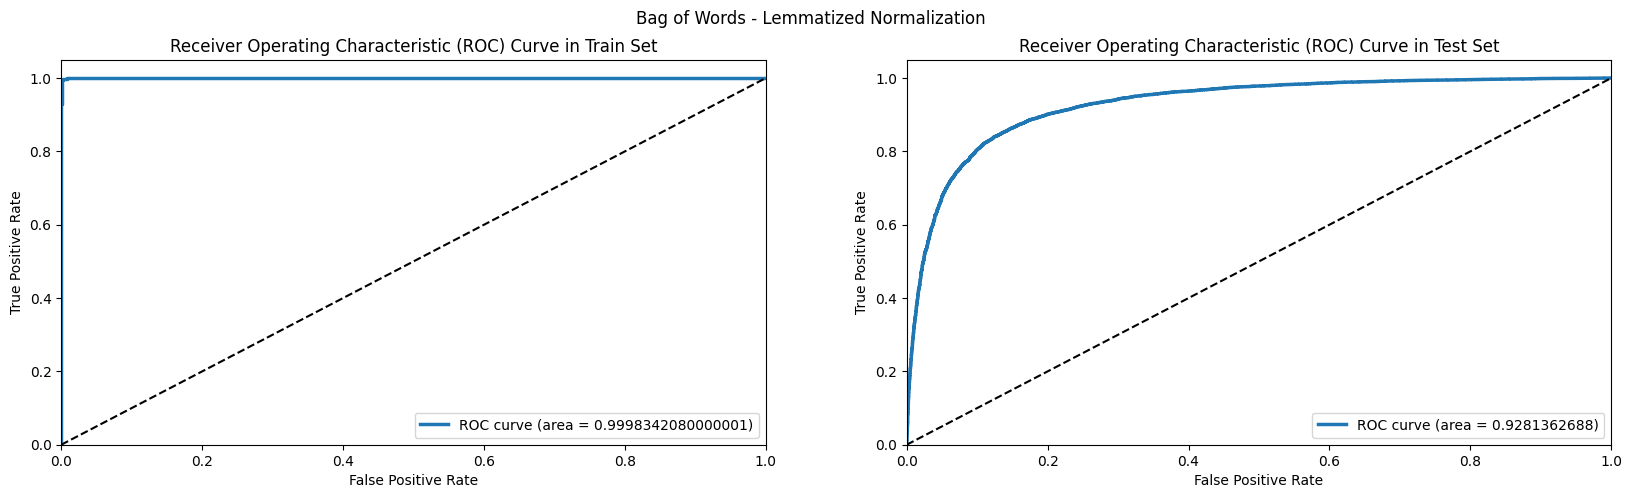

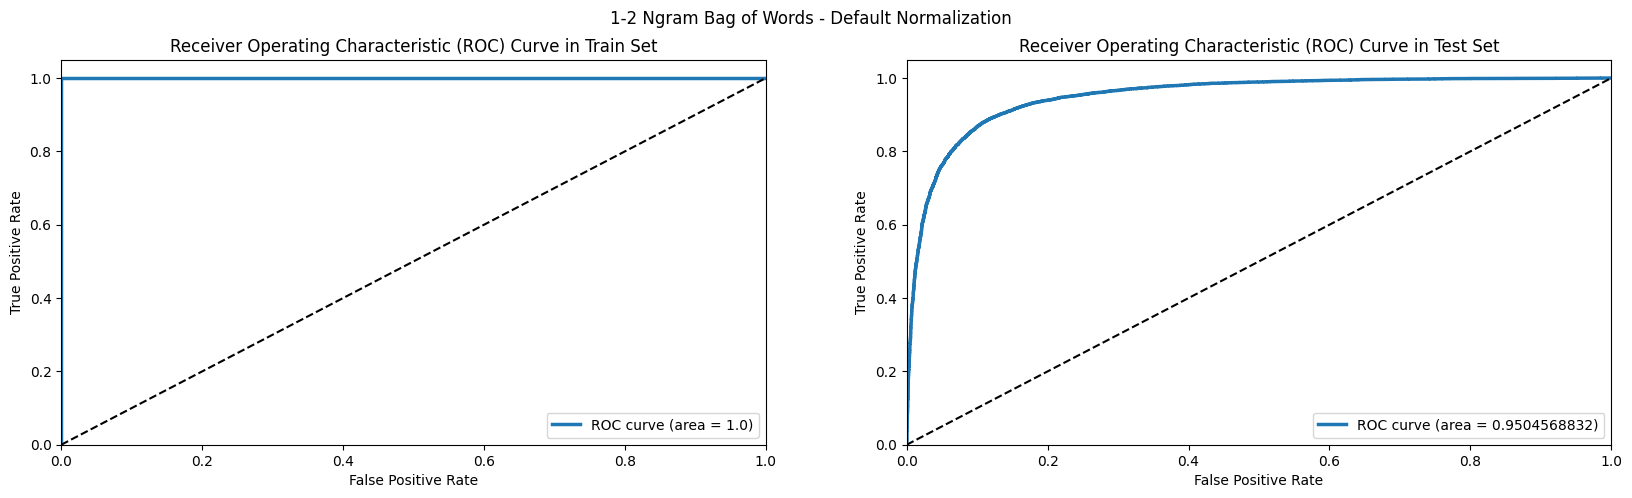

In [71]:
roc_auc_train, roc_auc_test = evaluation.plot_roc_train_test(model, B_O_W_train, y_train, B_O_W_test, y_test, sup_title="Bag of Words - Default Normalization")
roc_auc_stem_train, roc_auc_stem_test  = evaluation.plot_roc_train_test(model_stem, B_O_W_train_stem, y_train, B_O_W_test_stem, y_test, sup_title="Bag of Words - Stemmed Normalization")
roc_auc_lemma_train, roc_auc_lemma_test = evaluation.plot_roc_train_test(model_lemma, B_O_W_train_lemma, y_train, B_O_W_test_lemma, y_test, sup_title="Bag of Words - Lemmatized Normalization")
roc_auc_n2_train, roc_auc_n2_test    = evaluation.plot_roc_train_test(model_n2, B_O_W_train_n2, y_train, B_O_W_test_n2, y_test, sup_title="1-2 Ngram Bag of Words - Default Normalization")

In [108]:
roc_auc = roc_auc_n2_test
def check_roc(roc_auc):
    if roc_auc > 0.93:
        print('Success!')
    else:
        raise ValueError('Your model is not good enough!')

check_roc(roc_auc)

Success!


### Logistic Regression with TF-IDF

In [88]:
model_tfidf = LogisticRegression(random_state = 7)
model_tfidf.fit(TFIDF_train, y_train)
y_train_pred_tfidf       = model_tfidf.predict(TFIDF_train)
y_pred_tfidf             = model_tfidf.predict(TFIDF_test)

model_stem_tfidf = LogisticRegression(random_state=7)
model_stem_tfidf.fit(TFIDF_train_stem, y_train)
y_train_pred_stem_tfidf  = model_stem_tfidf.predict(TFIDF_train_stem)
y_pred_stem_tfidf        = model_stem_tfidf.predict(TFIDF_test_stem)

model_lemma_tfidf = LogisticRegression(random_state=7)
model_lemma_tfidf.fit(TFIDF_train_lemma, y_train)
y_train_pred_lemma_tfidf = model_lemma_tfidf.predict(TFIDF_train_lemma)
y_pred_lemma_tfidf       = model_lemma_tfidf.predict(TFIDF_test_lemma)

model_n2_tfidf = LogisticRegression(random_state = 7)
model_n2_tfidf.fit(TFIDF_train_n2, y_train)
y_train_pred_n2_tfidf    = model_n2_tfidf.predict(TFIDF_train_n2)
y_pred_n2_tfidf          = model_n2_tfidf.predict(TFIDF_test_n2)


In [ ]:
print("*****************   Default   *****************")
accuracy_tfidf, precision_tfidf, recall_tfidf, f1_score_tfidf = evaluation.get_performance(
        y_pred_tfidf, 
        y_test
    )
print("*****************   Stemming   *****************")
accuracy_stem_tfidf, precision_stem_tfidf, recall_stem_tfidf, f1_score_stem_tfidf = evaluation.get_performance(
        y_pred_stem_tfidf, 
        y_test
    )

In [96]:
print("***************** Lemmatization *****************")
accuracy_lemma_tfidf, precision_lemma_tfidf, recall_lemma_tfidf, f1_score_lemma_tfidf = evaluation.get_performance(
        y_pred_lemma_tfidf, 
        y_test
    )
    
print("************** Defaul ngramn=(1,2) **************")
accuracy_lemma_tfidf, precision_lemma_tfidf, recall_lemma_tfidf, f1_score_lemma_tfidf = evaluation.get_performance(
        y_pred_n2_tfidf, 
        y_test
    )

***************** Lemmatization *****************
Model Performance metrics:
------------------------------
Accuracy: 0.87632
Precision: 0.8742243436754177
Recall: 0.87912
F1 Score: 0.8766653370562425

Model Classification report:
------------------------------
(array([0.87843926, 0.87422434]), array([0.87352, 0.87912]), array([0.87597272, 0.87666534]), array([12500, 12500]))

Prediction Confusion Matrix:
------------------------------
       0      1
0  10919   1581
1   1511  10989
************** Defaul ngramn=(1,2) **************
Model Performance metrics:
------------------------------
Accuracy: 0.87824
Precision: 0.8729883243925528
Recall: 0.88528
F1 Score: 0.8790911979663171

Model Classification report:
------------------------------
(array([0.88364167, 0.87298832]), array([0.8712 , 0.88528]), array([0.87737673, 0.8790912 ]), array([12500, 12500]))

Prediction Confusion Matrix:
------------------------------
       0      1
0  10890   1610
1   1434  11066


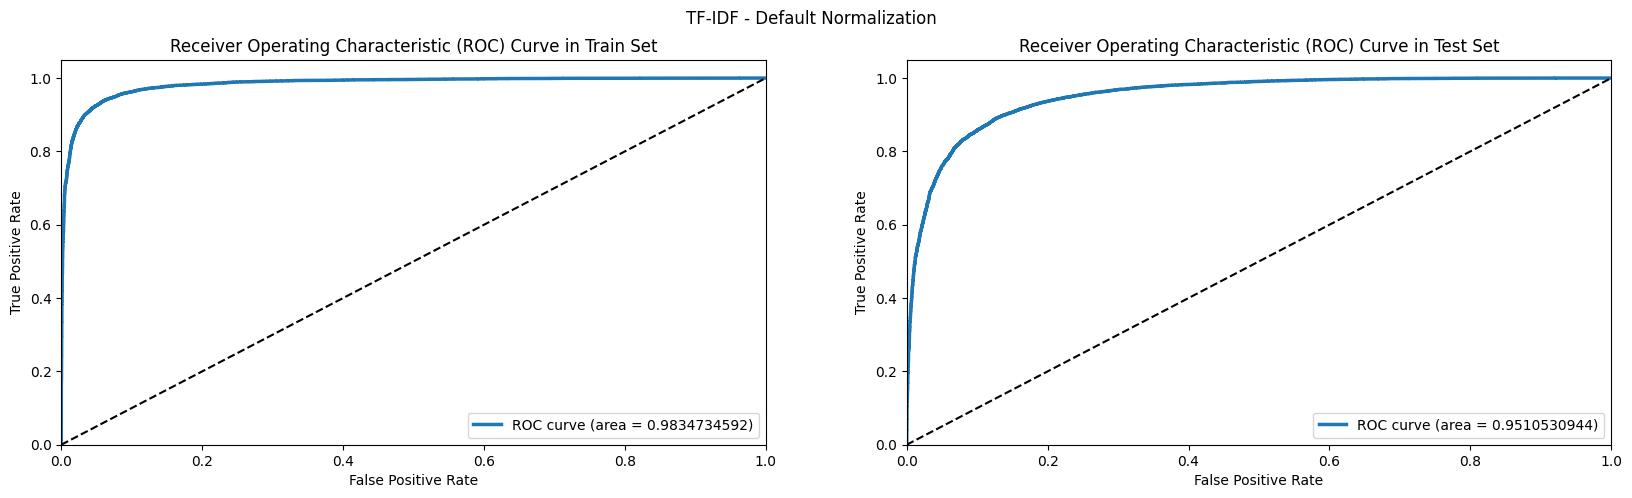

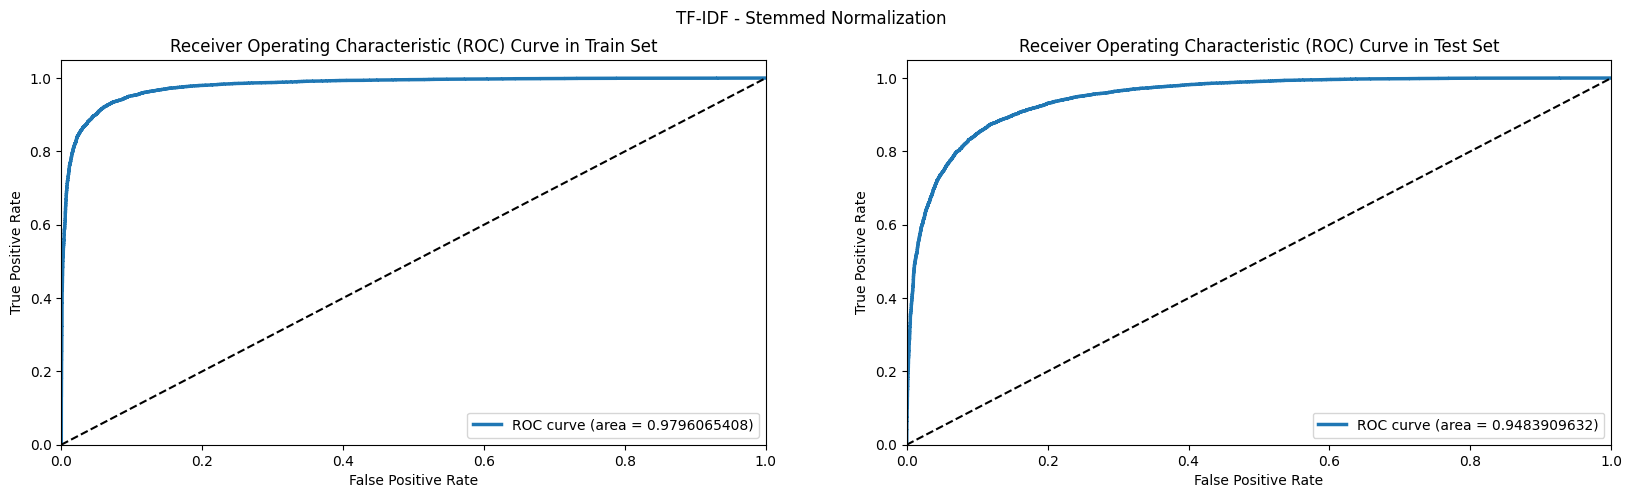

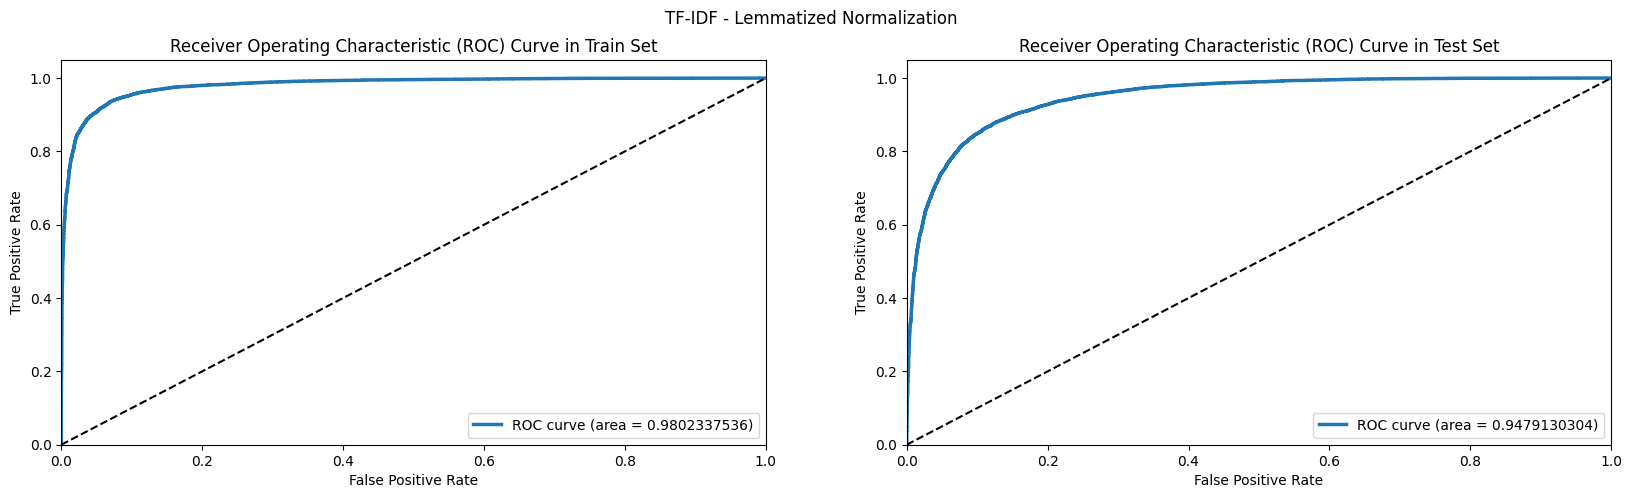

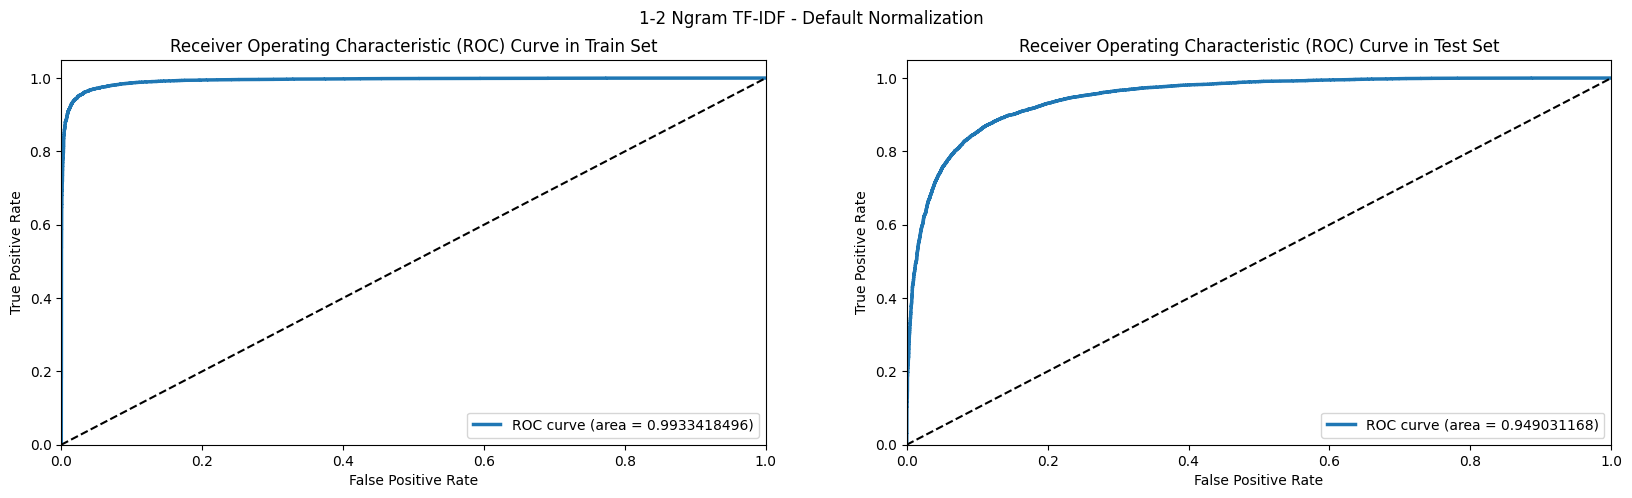

In [90]:
roc_auc_train_tfidf, roc_auc_test_tfidf             = evaluation.plot_roc_train_test(model_tfidf, TFIDF_train, y_train, TFIDF_test, y_test, sup_title="TF-IDF - Default Normalization")
roc_auc_stem_train_tfidf, roc_auc_stem_test_tfidf   = evaluation.plot_roc_train_test(model_stem_tfidf, TFIDF_train_stem, y_train, TFIDF_test_stem, y_test, sup_title="TF-IDF - Stemmed Normalization")
roc_auc_lemma_train_tfidf, roc_auc_lemma_test_tfidf = evaluation.plot_roc_train_test(model_lemma_tfidf, TFIDF_train_lemma, y_train, TFIDF_test_lemma, y_test, sup_title="TF-IDF - Lemmatized Normalization")
roc_auc_n2_train_tfidf, roc_auc_n2_test_tfidf       = evaluation.plot_roc_train_test(model_n2_tfidf, TFIDF_train_n2, y_train, TFIDF_test_n2, y_test, sup_title="1-2 Ngram TF-IDF - Default Normalization")

### Conclusions:

- ROC for training and testing were close in all the experiments, so there is no sign of overfitting nor underfitting
- Default normaliztion gave better results than stemmed or lemmatized normalization for both Bag Of Words and TF-IDF
- TF-IDF with default normalization gave better results than Bag Of Words with default normalization (0.95105 vs 0.93485)
- Using Ngram improved the results compared to default normalization using Bag Of Words, but worsened the results using TF-IDF
- All the experiments were made using a sklearn Logistic Regression model with default hyperparameters

---
## 5. Feature Engineering with Custom Word Embedding

### Tokenize reviews and train your own Word Embedding

You are going to have to train your own word embedding, for this we are going to use the __gensim__ library. The only requirement we ask of you is that the $vector\_size=100$.

[Here](https://radimrehurek.com/gensim/models/word2vec.html) you can read Gensim's Word2Vec documentation so you can train your own embedding, using the review data as a corpus.

As a previous step to training your word embedding you must tokenize the corpus, this may take a bit depending on the size of the dataset and the tokenizer we use, if you want you can try the NLTK tokenizer called `ToktokTokenizer`, which turns out to be a little faster (we hope that this recommendation does not bias your work, try and use the ones you want)

In [147]:
tokenizer = ToktokTokenizer()
X_train_tokenized = [tokenizer.tokenize(doc) for doc in X_train_n]
X_test_tokenized = [tokenizer.tokenize(doc) for doc in X_test_n]
phrase_model = Phrases(X_train_tokenized, connector_words=ENGLISH_CONNECTOR_WORDS)
model_w2v = Word2Vec(sentences=phrase_model[X_train_tokenized], vector_size=100, workers=8)

### Generate averaged word vector features

Once the embedding has been trained, we must use it. Remember that embedding will convert each word you pass to it into a vector of a given dimension (in our case $vector\_size=100$). So in order to obtain a vector for each review, you must average the vectors of all the words that are part of the same review.

The function must have the following form:
* `vectorizer(corpus, model, num_features=100)`


Where:
* `corpus:` corresponds to the entire dataset, in this way we obtain an average vector for each review, with a single call to the function.
* `model:` is your trained model.
* `num_features:` the dimension of the output vector of your embedding (remember that in our case we set this value to 100).

In [100]:
def vectorizer(corpus, model, num_features=100, pre_trained=False):
    """
    Parameters
    ----------
    corpus: array
      array of normalized reviews.
    model:
      Word to Vec model
    num_features: int = 100
      Output vector dimension
    pre_trained : bool = False
      Wheter model is a pretrained gensim model or not
    Return
    ------
      Tuple containing Array of vectorized normalized reviews;
      and list of words not found in the model's vocabulary
    """
    if pre_trained:
      model = model
      vocabulary = model
    else:
      model = model.wv
      vocabulary = model.index_to_key
    corpus_vectors = []
    words_not_in_vocabulary = set()
    for doc in corpus:
        sum = np.zeros(num_features)
        word_count = 0
        for word in doc:
            if word in vocabulary:
                sum+=model[word]
                word_count+=1
            else:
                words_not_in_vocabulary.add(word)
        corpus_vectors.append(sum/word_count)
    print(len(words_not_in_vocabulary), " words not found in vocabulary.")
    
    return corpus_vectors, words_not_in_vocabulary

In [97]:
a = {'a':1, 'b':2}

In [148]:
# Get train andtest vectorized corpuses
try:
  corpus_vectorized_train = utils.load_object('corpus_vectorized_train.pickle')
except:
  corpus_vectorized_train = utils.save_object(vectorizer(X_train_tokenized, model_w2v), 'corpus_vectorized_train.pickle')
try:
  corpus_vectorized_test = utils.load_object('corpus_vectorized_test.pickle')
except:
  corpus_vectorized_test = utils.save_object(vectorizer(X_test_tokenized, model_w2v), 'corpus_vectorized_test.pickle')

107243  words not found in vocabulary.
106065  words not found in vocabulary.


### *Don't change anything in this block, just make it run correctly*

Let's do a simple check of the embedding that you just trained.

In [149]:
def check_embedding(model):
    vector = model.wv['computer']
    if len(vector) == 100:
        print(
            'Success! Your embedding tells me that "women" and "man" '
            f'are similar with a score of {model.wv.similarity("woman", "man")}'
        )
    else:
        raise ValueError('You should check your embedding vector size!')
        
check_embedding(model_w2v)

Success! Your embedding tells me that "women" and "man" are similar with a score of 0.8343599438667297


Now, we are going to check the vectorizer, remember that the vectorizer must generate an average vector of all the words present in the same review. So we're going to get two vectors of two words and manually average them, then using those two words we'll simulate a tokenized sentence and see that it matches the manual way.

In [155]:
def check_vectorizer(model):
    vector1 = model.wv['personal']
    vector2 = model.wv['computer']
    avg = vectorizer([['personal', 'computer']], model)[0][0]

    if np.allclose((vector1 + vector2) / 2, avg):
        print('Success!')
    else:
        raise ValueError('You should check your vectorizer!')
        
check_vectorizer(model_w2v)

0  words not found in vocabulary.
Success!


### Modeling

Finally train a new model, it can be the same one you used before and compare the results you got using BoW/TF-IDF and Word2Vec.

In addition to training the model we ask you to show:

* `Accuracy`
* `Recall`
* `F1-Score`
* `Classification Report`
* `Confusion Matrix`
* `ROC Curve`
* `Obtain the ROC-AUC value (later we will do a small minimum performance check with this value)`

### Logistic Regression With Default Word 2 Vec and Ngram

In [158]:
model_word2vec = LogisticRegression(random_state = 7)
model_word2vec.fit(corpus_vectorized_train[0], y_train)
y_train_pred_word2vec = model_word2vec.predict(corpus_vectorized_train[0])
y_pred_word2vec       = model_word2vec.predict(corpus_vectorized_test[0])

print("*****************  Word2Vec   *****************")
accuracy_word2vec, precision_word2vec, recall_word2vec, f1_score_word2vec = evaluation.get_performance(
        y_pred_word2vec, 
        y_test
    )

/home/jotace/anaconda3/envs/aaiSP5-3.8.13/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


*****************  Word2Vec   *****************
Model Performance metrics:
------------------------------
Accuracy: 0.79556
Precision: 0.7918938136999288
Recall: 0.80184
F1 Score: 0.7968358707318043

Model Classification report:
------------------------------
(array([0.79931945, 0.79189381]), array([0.78928, 0.80184]), array([0.794268  , 0.79683587]), array([12500, 12500]))

Prediction Confusion Matrix:
------------------------------
      0      1
0  9866   2634
1  2477  10023


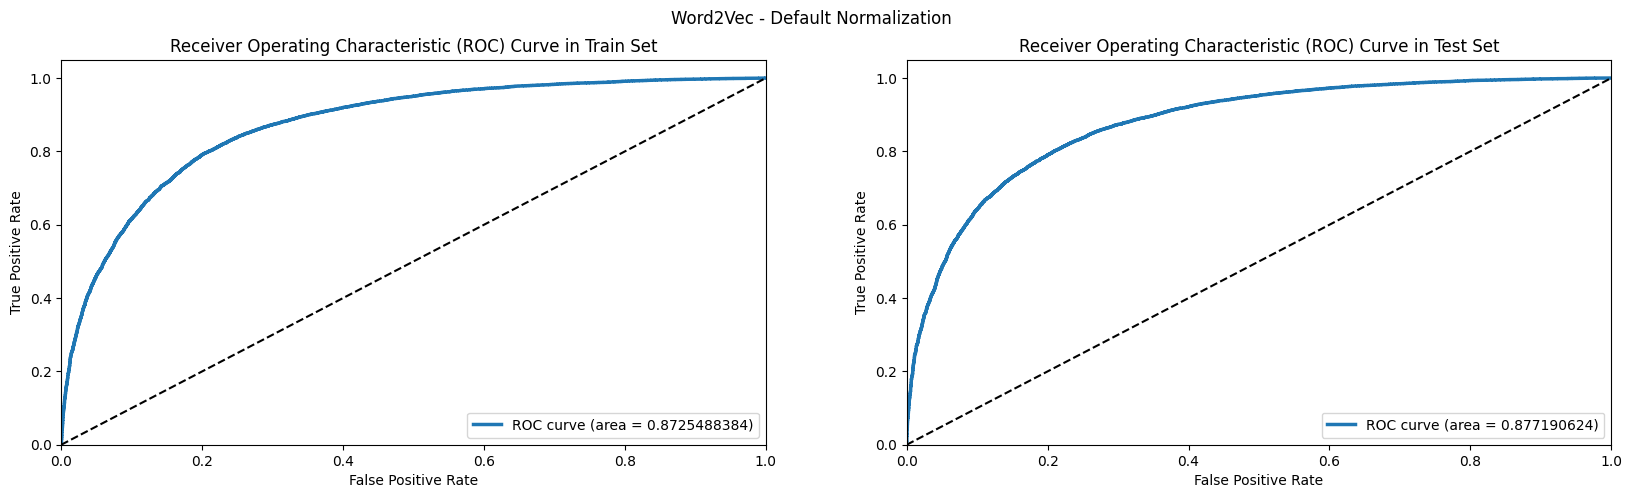

In [159]:
roc_auc_train_word2vec, roc_auc_test_word2vec = evaluation.plot_roc_train_test(model_word2vec, corpus_vectorized_train[0], y_train, corpus_vectorized_test[0], y_test, sup_title="Word2Vec - Default Normalization - Ngram")

We are getting 0.87719 ROC in test set (< 0.93)

Let's tryt now with lemmatized normalization.

### Logistic Regression With Lemmatized Word 2 Vec and Ngram

In [4]:
tokenizer = ToktokTokenizer()
X_train_tokenized_lemma = [tokenizer.tokenize(doc) for doc in X_train_n_lemma]
X_test_tokenized_lemma = [tokenizer.tokenize(doc) for doc in X_test_n_lemma]
phrase_model_lemma = Phrases(X_train_tokenized_lemma, connector_words=ENGLISH_CONNECTOR_WORDS)
model_w2v_lemma = Word2Vec(sentences=phrase_model_lemma[X_train_tokenized_lemma], vector_size=100, workers=8)
try:
  corpus_vectorized_train_lemma = utils.load_object('corpus_vectorized_train_lemma.pickle')
except:
  corpus_vectorized_train_lemma = utils.save_object(vectorizer(X_train_tokenized_lemma, model_w2v_lemma), 'corpus_vectorized_train_lemma.pickle')
try:
  corpus_vectorized_test_lemma = utils.load_object('corpus_vectorized_test_lemma.pickle')
except:
  corpus_vectorized_test_lemma = utils.save_object(vectorizer(X_test_tokenized_lemma, model_w2v_lemma), 'corpus_vectorized_test_lemma.pickle')

97922  words not found in vocabulary.
96605  words not found in vocabulary.


In [7]:
model_word2vec_lemma = LogisticRegression(random_state = 7)
model_word2vec_lemma.fit(corpus_vectorized_train_lemma[0], y_train)
y_train_pred_word2vec_lemma = model_word2vec_lemma.predict(corpus_vectorized_train_lemma[0])
y_pred_word2vec_lemma       = model_word2vec_lemma.predict(corpus_vectorized_test_lemma[0])

print("*****************  Word2Vec   *****************")
accuracy_word2vec_lemma, precision_word2vec_lemma, recall_word2vec_lemma, f1_score_word2vec_lemma = evaluation.get_performance(
        y_pred_word2vec_lemma, 
        y_test
    )

*****************  Word2Vec   *****************
Model Performance metrics:
------------------------------
Accuracy: 0.80372
Precision: 0.8002372479240807
Recall: 0.80952
F1 Score: 0.8048518592165441

Model Classification report:
------------------------------
(array([0.8072845 , 0.80023725]), array([0.79792, 0.80952]), array([0.80257493, 0.80485186]), array([12500, 12500]))

Prediction Confusion Matrix:
------------------------------
      0      1
0  9974   2526
1  2381  10119


/home/jotace/anaconda3/envs/aaiSP5-3.8.13/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


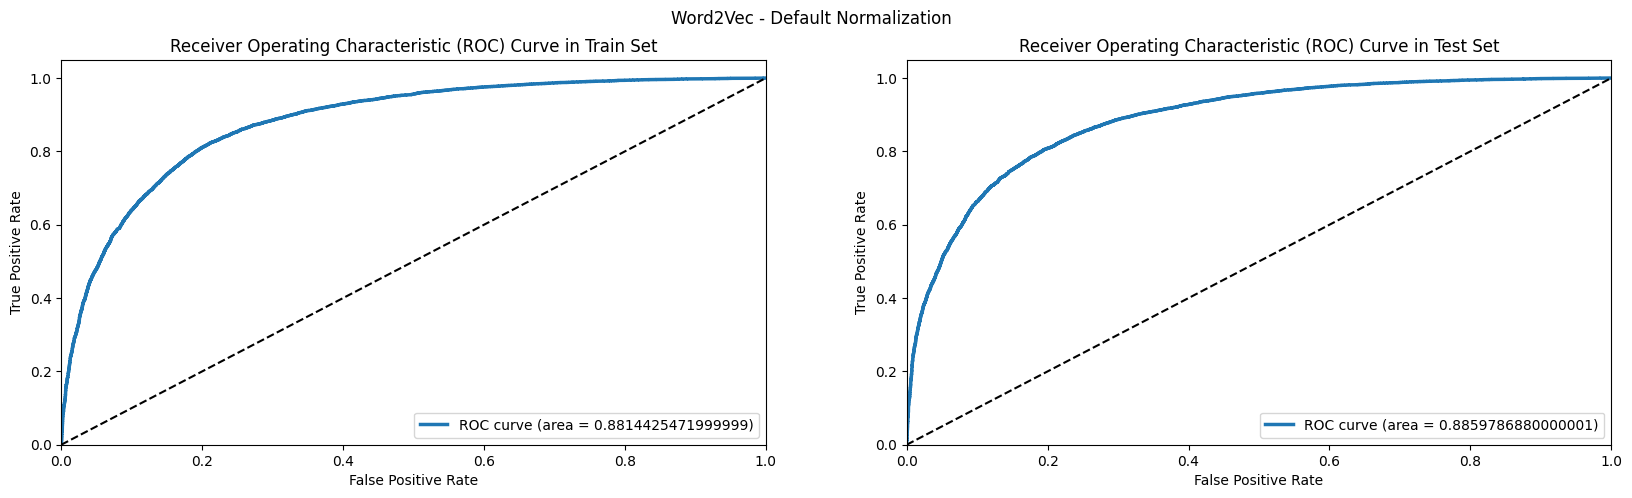

In [ ]:
roc_auc_train_word2vec_lemma, roc_auc_test_word2vec_lemma = evaluation.plot_roc_train_test(
                                                          model_word2vec_lemma,
                                                          corpus_vectorized_train_lemma[0],
                                                          y_train,
                                                          corpus_vectorized_test_lemma[0],
                                                          y_test,
                                                          sup_title="Word2Vec - Lemmatized Normalization - Ngram")

We had an improvement with respect to default normalization Word 2 Vec (0.88597 vs 0.87719) but we are still below the required ROC

### Logistic Regression With Lemmatized Word 2 Vec and Ngram and Using Unsupervised dataset

In [ ]:
# Load unlabeled data and normalize it with lemmatization
try:
  X_unsup = utils.load_object('unsup_norm.pickle')
except:    
  X_unsup = []
  for path in utils.walkdir("aclImdb/train/unsup/"):
    with open(os.path.join(*path)) as f:
      X_unsup.append(f.read())
  X_unsup_n = utils.save_object(text_normalizer.normalize_data(X_unsup, text_lemmatization=Tr), 'unsup_norm.pickle')

In [62]:
# Concatenate unlabeld data with train data
X_train_n_lemma_with_unsup = X_train_n_lemma.copy()
X_train_n_lemma_with_unsup.extend(X_unsup_n)

In [65]:
# Tokenize train and test
tokenizer = ToktokTokenizer()
X_train_tokenized_lemma_with_unsup = [tokenizer.tokenize(doc) for doc in X_train_n_lemma_with_unsup]

# word to vec model
phrase_model_lemma_with_unsup = Phrases(X_train_tokenized_lemma_with_unsup, connector_words=ENGLISH_CONNECTOR_WORDS)
model_w2v_lemma_with_unsup = Word2Vec(sentences=phrase_model_lemma_with_unsup[X_train_tokenized_lemma_with_unsup], vector_size=100, workers=8)

# Get train and test features
try:
  corpus_vectorized_train_lemma_with_unsup = utils.load_object('corpus_vectorized_train_lemma_with_unsup.pickle')
except:
  corpus_vectorized_train_lemma_with_unsup = utils.save_object(vectorizer(X_train_tokenized_lemma, model_w2v_lemma_with_unsup), 'corpus_vectorized_train_lemma_with_unsup.pickle')
try:
  corpus_vectorized_test_lemma_with_unsup = utils.load_object('corpus_vectorized_test_lemma_with_unsup.pickle')
except:
  corpus_vectorized_test_lemma_with_unsup = utils.save_object(vectorizer(X_test_tokenized_lemma, model_w2v_lemma_with_unsup), 'corpus_vectorized_test_lemma_with_unsup.pickle')

83033  words not found in vocabulary.
83356  words not found in vocabulary.


In [73]:
model_word2vec_lemma_with_unsup = LogisticRegression(random_state = 7)
model_word2vec_lemma_with_unsup.fit(corpus_vectorized_train_lemma_with_unsup[0], y_train)
y_train_pred_word2vec_lemma_with_unsup = model_word2vec_lemma_with_unsup.predict(corpus_vectorized_train_lemma_with_unsup[0])
y_pred_word2vec_lemma_with_unsup       = model_word2vec_lemma_with_unsup.predict(corpus_vectorized_test_lemma_with_unsup[0])

print("*****************  Word2Vec   *****************")
accuracy_word2vec_lemma_with_unsup, precision_word2vec_lemma_with_unsup, recall_word2vec_lemma_with_unsup, f1_score_word2vec_lemma_with_unsup = evaluation.get_performance(
        y_pred_word2vec_lemma_with_unsup, 
        y_test
    )

*****************  Word2Vec   *****************
Model Performance metrics:
------------------------------
Accuracy: 0.85744
Precision: 0.8548848292295472
Recall: 0.86104
F1 Score: 0.8579513750498207

Model Classification report:
------------------------------
(array([0.86003223, 0.85488483]), array([0.85384, 0.86104]), array([0.85692493, 0.85795138]), array([12500, 12500]))

Prediction Confusion Matrix:
------------------------------
       0      1
0  10673   1827
1   1737  10763


/home/jotace/anaconda3/envs/aaiSP5-3.8.13/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


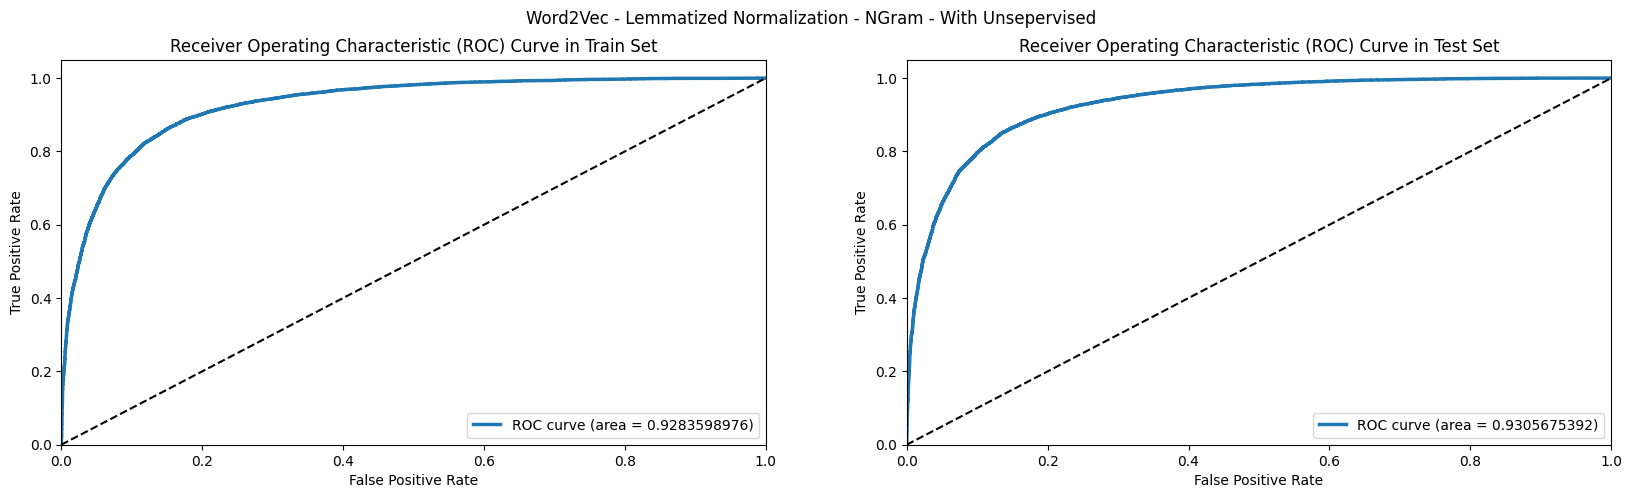

In [74]:
roc_auc_train_word2vec_lemma_with_unsup, roc_auc_test_word2vec_lemma_with_unsup = evaluation.plot_roc_train_test(
                                                              model_word2vec_lemma_with_unsup,
                                                              corpus_vectorized_train_lemma_with_unsup[0],
                                                              y_train,
                                                              corpus_vectorized_test_lemma_with_unsup[0],
                                                              y_test,
                                                              sup_title="Word2Vec - Lemmatized Normalization - NGram - With Unsepervised")

We got a ROC of 0.93057

### *Don't change anything in this block, just make it run correctly*

In [78]:
check_roc(roc_auc_test_word2vec_lemma_with_unsup)

Success!


---
### OPTIONAL:

In our case, we train a word embedding from scratch, which is very good at an educational level, but when applying it to a real problem, we need a lot of data (which is not the case with our problem). Therefore, we invite you to investigate and use one of the `pre-trained Word2Vec models`.

If you look for the `Pretrained models` section in this [link](https://radimrehurek.com/gensim/models/word2vec.html), you will find information about the models that Gensim owns.

In [85]:
print(list(gensim.downloader.info()['models'].keys()))

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


In [103]:
model_glove = gensim.downloader.load('glove-wiki-gigaword-200')

In [102]:
try:
  corpus_glove_train_lemma = utils.load_object('corpus_glove_train_lemma.pickle')
except:
  corpus_glove_train_lemma = utils.save_object(vectorizer(X_train_tokenized_lemma, model_glove, num_features=200, pre_trained=True), 'corpus_glove_train_lemma.pickle')
try:
  corpus_glove_test_lemma  = utils.load_object('corpus_glove_test_lemma.pickle')
except:
  corpus_glove_test_lemma  = utils.save_object(vectorizer(X_test_tokenized_lemma, model_glove, num_features=200, pre_trained=True), 'corpus_glove_test_lemma.pickle')

74026  words not found in vocabulary.
71811  words not found in vocabulary.


In [106]:
model_glove_lemma = LogisticRegression(random_state = 7)
model_glove_lemma.fit(corpus_glove_train_lemma[0], y_train)
y_train_pred_glove_lemma = model_glove_lemma.predict(corpus_glove_train_lemma[0])
y_pred_glove_lemma       = model_glove_lemma.predict(corpus_glove_test_lemma[0])

print("*****************  Glove200   *****************")
accuracy_glove_lemma, precision_glove_lemma, recall_glove_lemma, f1_score_glove_lemma = evaluation.get_performance(
        y_pred_glove_lemma, 
        y_test
    )

/home/jotace/anaconda3/envs/aaiSP5-3.8.13/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


*****************  Glove200   *****************
Model Performance metrics:
------------------------------
Accuracy: 0.81976
Precision: 0.821509009009009
Recall: 0.81704
F1 Score: 0.8192684100754052

Model Classification report:
------------------------------
(array([0.81802992, 0.82150901]), array([0.82248, 0.81704]), array([0.82024892, 0.81926841]), array([12500, 12500]))

Prediction Confusion Matrix:
------------------------------
       0      1
0  10281   2219
1   2287  10213


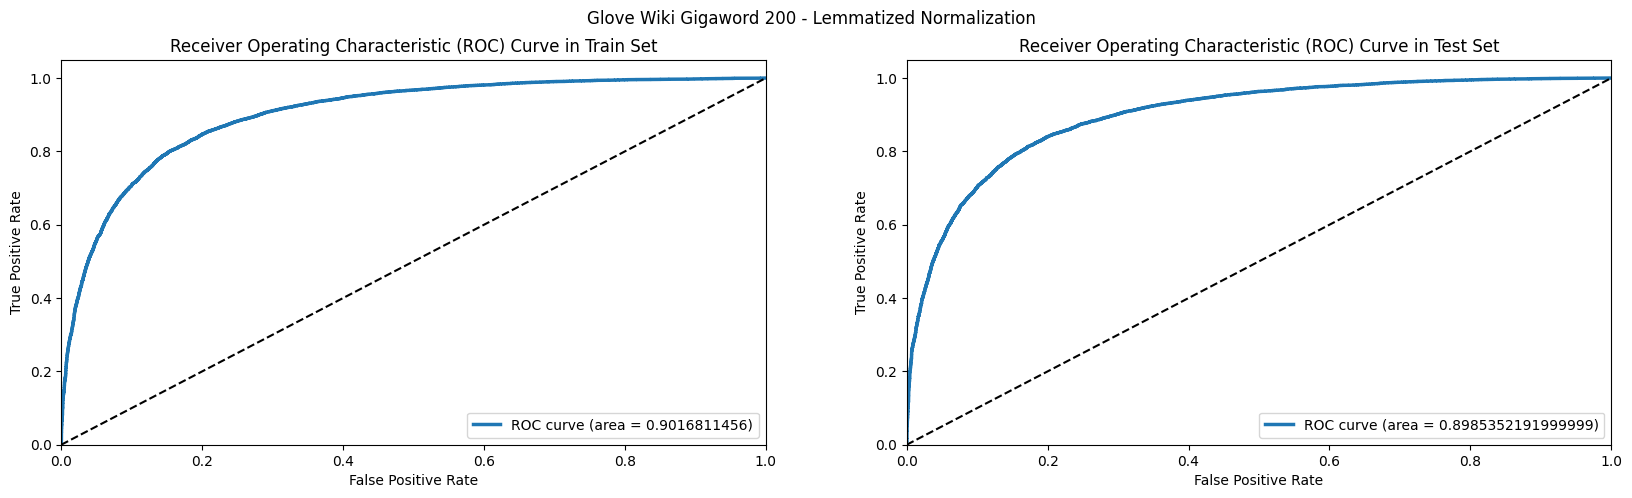

In [107]:
roc_auc_train_glove_lemma, roc_auc_test_glove_lemma = evaluation.plot_roc_train_test(
                                                              model_glove_lemma,
                                                              corpus_glove_train_lemma[0],
                                                              y_train,
                                                              corpus_glove_test_lemma[0],
                                                              y_test,
                                                              sup_title="Glove Wiki Gigaword 200 - Lemmatized Normalization")

## Final Conclusions

Some conclusions based on our experiments are

- Applying stemming or lemmatization in the normalizer pipeline is not a guarantee of improvemnt
- Using ngram does not make a significant impact in the model predictive power. We need to consider if much more training time worth centecimals of ROC.
- Machine learning applied to NLP problems leads to very good result with not so big dataset even with baseline model. We could get better result trying different models or by applying Grid/Random Search but I consider that is not the purpose of this project.